In [ ]:
import pandas as pd
import numpy as np
import json
import websocket

In [ ]:
!pip install python-binance pandas mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 72.2 MB/s eta 0:00:00


In [ ]:
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd

In [ ]:
import requests
import pandas as pd
import time

API_KEY = '8f4b6bfb5af337af6d9417f68c9e9e6d2b855f818e6be2fd8220fa83806756d7'
BASE_URL = "https://min-api.cryptocompare.com/data/v2/histoday"
coins = ['BTC', 'ETH', 'SOL', 'XRP', 'USDT']
to_symbol = 'USD'

def fetch_chunk(coin_symbol, to_timestamp, limit=2000):
    params = {
        'fsym': coin_symbol,
        'tsym': to_symbol,
        'limit': limit,
        'toTs': to_timestamp,
        'api_key': API_KEY
    }
    r = requests.get(BASE_URL, params=params)
    data = r.json()
    if data['Response'] != 'Success':
        print(f"[ERROR] {coin_symbol}: {data.get('Message')}")
        return None
    df = pd.DataFrame(data['Data']['Data'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volumefrom': 'VolumeFrom',
        'volumeto': 'VolumeTo'
    })
    return df[['Date', 'Open', 'High', 'Low', 'Close', 'VolumeFrom', 'VolumeTo']]

# Timestamps
# Jan 1, 2022 → 1640995200
# Jan 1, 2019 → 1546300800

dataframes = {}

for coin in coins:
    print(f"\n[INFO] Fetching {coin}...")

    # Older chunk (2019–2021)
    df1 = fetch_chunk(coin, to_timestamp=1640995200, limit=1095)  # ~3 years
    time.sleep(1)

    # Recent chunk (2022–now)
    df2 = fetch_chunk(coin, to_timestamp=int(time.time()), limit=1095)
    time.sleep(1)

    if df1 is not None and df2 is not None:
        df_combined = pd.concat([df1, df2])
        df_combined = df_combined.drop_duplicates(subset='Date').sort_values('Date')
        dataframes[coin] = df_combined
        df_combined.to_csv(f'{coin}_2019_2024_OHLCV.csv', index=False)
        print(f"[DONE] {coin}: {len(df_combined)} rows saved.")
    else:
        print(f"[FAIL] Could not fetch all chunks for {coin}.")

# Check BTC
print("\nSample BTC Data:")
print(dataframes['BTC'].head())



[INFO] Fetching BTC...
[DONE] BTC: 2192 rows saved.

[INFO] Fetching ETH...
[DONE] ETH: 2192 rows saved.

[INFO] Fetching SOL...
[DONE] SOL: 2192 rows saved.

[INFO] Fetching XRP...
[DONE] XRP: 2192 rows saved.

[INFO] Fetching USDT...
[DONE] USDT: 2192 rows saved.

Sample BTC Data:
        Date     Open     High      Low    Close  VolumeFrom      VolumeTo
0 2019-01-02  3880.15  3989.59  3826.29  3961.01    54034.73  2.108546e+08
1 2019-01-03  3961.01  3965.52  3778.76  3835.86    45585.19  1.764881e+08
2 2019-01-04  3835.86  3901.65  3783.88  3874.06    44398.90  1.705076e+08
3 2019-01-05  3874.06  3926.92  3841.13  3855.39    35766.65  1.394385e+08
4 2019-01-06  3855.39  4145.16  3829.09  4102.85    58878.99  2.362980e+08


In [ ]:
# STEP 1: Load your dataset
sentiment_df = pd.read_csv('/content/bitcoin_sentiments_21_24.csv')  # replace with your actual filename

In [ ]:
sentiment_df

,Date,Short Description,Accurate Sentiments
0,2021-11-05 04:42:00,Bitcoin price is consolidating near the USD 62...,0.998558
1,2021-11-05 08:15:00,Congress could finally approve or reject the m...,0.000000
2,2021-11-05 10:24:00,Bitcoin increasingly becoming a political inst...,0.000000
3,2021-11-05 16:58:00,There is still potential for the price of bitc...,0.999458
4,2021-11-05 21:00:00,'Several companies' are looking to Latin Ameri...,0.000000
...,...,...,...
11290,2024-09-12 00:00:00,The government of El Salvador has been buying ...,0.000000
11291,2024-09-12 00:00:00,"According to data from mempool.space, transact...",0.997017
11292,2024-09-12 00:00:00,Time Magazine reporter Vera Bergengruen believ...,0.000000
11293,2024-09-12 00:00:00,"in bitcoin is concentrated at around $58,500,...",0.000000


In [ ]:
# STEP 2: Parse the date column
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

In [ ]:
# STEP 3: Aggregate by day
daily_sentiment = sentiment_df.groupby(sentiment_df['Date'].dt.date).agg({
    'Accurate Sentiments': ['mean', 'count']
}).reset_index()

In [ ]:
daily_sentiment

Date Accurate Sentiments      
                               mean count
0    2021-11-05            0.399603     5
1    2021-11-06            0.000000     1
2    2021-11-08           -0.209941     4
3    2021-11-09            0.249908     4
4    2021-11-10           -0.249181     4
..          ...                 ...   ...
882  2024-09-08           -0.144635     9
883  2024-09-09            0.293141    24
884  2024-09-10            0.632223    22
885  2024-09-11           -0.390417    27
886  2024-09-12            0.184635    21

[887 rows x 3 columns]

In [ ]:
import pandas as pd

# Load BTC sentiment
# sentiment_df = pd.read_csv("btc_daily_sentiment.csv") # This file does not exist
sentiment_df = daily_sentiment # Use the dataframe created in the previous step
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Dictionary of coin file names
coin_files = {
    'BTC': 'BTC_2019_2024_OHLCV.csv',
    'ETH': 'ETH_2019_2024_OHLCV.csv',
    'SOL': 'SOL_2019_2024_OHLCV.csv',
    'XRP': 'XRP_2019_2024_OHLCV.csv',
    'USDT': 'USDT_2019_2024_OHLCV.csv',
}

# Initialize master DataFrame
master_df = sentiment_df.rename(columns={'date': 'Date'})

# Loop through coins and merge
for coin, file in coin_files.items():
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])

    # Just keep the 'Close' column and rename it
    df = df[['Date', 'Close']].rename(columns={'Close': f'{coin}_Close'})

    # Merge with master_df
    master_df = pd.merge(master_df, df, on='Date', how='left')

# Optional: sort by date and drop NaNs (if you want only full rows)
master_df = master_df.sort_values('Date')
master_df = master_df.dropna()

# Save result
master_df.to_csv("crypto_sentiment_combined.csv", index=False)

# Preview
print(master_df.head())

MergeError: Not allowed to merge between different levels. (2 levels on the left, 1 on the right)

In [ ]:
import pandas as pd

# Load BTC sentiment
# sentiment_df = pd.read_csv("btc_daily_sentiment.csv")
sentiment_df = daily_sentiment # Use the dataframe created in the previous step
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Init master DataFrame
master_df = sentiment_df.rename(columns={'date': 'Date'})

# Coin file mapping
coin_files = {
    'BTC': 'BTC_2019_2024_OHLCV.csv',
    'ETH': 'ETH_2019_2024_OHLCV.csv',
    'SOL': 'SOL_2019_2024_OHLCV.csv',
    'XRP': 'XRP_2019_2024_OHLCV.csv',
    'USDT': 'USDT_2019_2024_OHLCV.csv',
}

for coin, file in coin_files.items():
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])

    # Calculate volatility = (High - Low) / Open
    df[f'{coin}_Volatility'] = (df['High'] - df['Low']) / df['Open']

    # Keep relevant columns and rename them
    df = df[['Date', 'Close', 'VolumeTo', f'{coin}_Volatility']]
    df = df.rename(columns={
        'Close': f'{coin}_Close',
        'VolumeTo': f'{coin}_Volume'
    })

    # Merge into master
    master_df = pd.merge(master_df, df, on='Date', how='left')

# Sort and clean
master_df = master_df.sort_values('Date').dropna()

# Save output
master_df.to_csv("crypto_sentiment_combined_full.csv", index=False)

# Preview
print(master_df.head())

        Date  mean_sentiment  article_count  BTC_Close    BTC_Volume  \
0 2021-11-05        0.399603              5   61019.66  1.262030e+09   
1 2021-11-06        0.000000              1   61529.76  9.395301e+08   
2 2021-11-08       -0.209941              4   67549.14  2.614940e+09   
3 2021-11-09        0.249908              4   66939.24  2.209552e+09   
4 2021-11-10       -0.249181              4   64926.06  3.365467e+09   

   BTC_Volatility  ETH_Close    ETH_Volume  ETH_Volatility  SOL_Close  \
0        0.029827    4480.09  1.023750e+09        0.028014     236.34   
1        0.023981    4521.41  8.892686e+08        0.044979     258.63   
2        0.070339    4810.97  1.401094e+09        0.044902     248.35   
3        0.032596    4732.07  1.331651e+09        0.027254     239.03   
4        0.086383    4632.98  2.133669e+09        0.079823     233.62   

     SOL_Volume  SOL_Volatility  XRP_Close    XRP_Volume  XRP_Volatility  \
0  6.158675e+08        0.071732      1.160  8.192506

In [ ]:
master_df

,Date,mean_sentiment,article_count,BTC_Close,BTC_Volume,BTC_Volatility,ETH_Close,ETH_Volume,ETH_Volatility,SOL_Close,SOL_Volume,SOL_Volatility,XRP_Close,XRP_Volume,XRP_Volatility,USDT_Close,USDT_Volume,USDT_Volatility
0,2021-11-05,0.399603,5,61019.66,1.262030e+09,0.029827,4480.09,1.023750e+09,0.028014,236.34,6.158675e+08,0.071732,1.1600,8.192506e+07,0.056572,1.001,20560.99,0.029770
1,2021-11-06,0.000000,1,61529.76,9.395301e+08,0.023981,4521.41,8.892686e+08,0.044979,258.63,7.632217e+08,0.105399,1.1520,5.194804e+07,0.065517,1.001,15450.19,0.023576
2,2021-11-08,-0.209941,4,67549.14,2.614940e+09,0.070339,4810.97,1.401094e+09,0.044902,248.35,7.817402e+08,0.050208,1.2830,1.461790e+08,0.061475,1.001,39794.74,0.066334
3,2021-11-09,0.249908,4,66939.24,2.209552e+09,0.032596,4732.07,1.331651e+09,0.027254,239.03,6.523042e+08,0.063096,1.2570,1.455686e+08,0.048324,1.000,32748.30,0.033267
4,2021-11-10,-0.249181,4,64926.06,3.365467e+09,0.086383,4632.98,2.133669e+09,0.079823,233.62,9.126253e+08,0.123206,1.1920,2.843568e+08,0.176611,1.001,50618.81,0.089100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2024-09-08,-0.144635,9,54879.33,1.042881e+09,0.031190,2297.39,9.561321e+08,0.040639,130.10,8.313184e+07,0.039154,0.5295,1.925622e+07,0.020194,1.000,19161.56,0.030600
883,2024-09-09,0.293141,24,57056.31,2.385673e+09,0.062210,2360.00,1.706418e+09,0.047093,135.08,1.797058e+08,0.077248,0.5396,3.553391e+07,0.030406,1.000,42650.30,0.059900
884,2024-09-10,0.632223,22,57642.43,1.908345e+09,0.028977,2388.83,1.213947e+09,0.033343,135.63,1.255649e+08,0.039828,0.5408,2.876032e+07,0.016679,1.000,33393.05,0.028600
885,2024-09-11,-0.390417,27,57354.27,3.160609e+09,0.042479,2340.73,1.893281e+09,0.046956,132.43,1.477404e+08,0.056625,0.5349,3.128762e+07,0.033469,1.000,55592.60,0.043100


In [ ]:
import pandas as pd

# Load BTC sentiment
# sentiment_df = pd.read_csv("btc_daily_sentiment.csv")
sentiment_df = daily_sentiment # Use the dataframe created in the previous step
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
master_df = sentiment_df.rename(columns={'date': 'Date'})

# Coin data files
coin_files = {
    'BTC': 'BTC_2019_2024_OHLCV.csv',
    'ETH': 'ETH_2019_2024_OHLCV.csv',
    'SOL': 'SOL_2019_2024_OHLCV.csv',
    'XRP': 'XRP_2019_2024_OHLCV.csv',
    'USDT': 'USDT_2019_2024_OHLCV.csv',
}

# Process each coin
for coin, file in coin_files.items():
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])

    # Keep necessary columns
    df = df[['Date', 'Close', 'VolumeTo']].rename(columns={
        'Close': f'{coin}_Close',
        'VolumeTo': f'{coin}_Volume'
    })

    # Merge Close & Volume into master
    master_df = pd.merge(master_df, df, on='Date', how='left')

# Sort and calculate returns & volatility
master_df = master_df.sort_values('Date')

# Add returns and realized volatility (7-day rolling std of returns)
for coin in ['BTC', 'ETH', 'SOL', 'XRP', 'USDT']:
    master_df[f'{coin}_Return'] = master_df[f'{coin}_Close'].pct_change()
    master_df[f'{coin}_Volatility'] = master_df[f'{coin}_Return'].rolling(window=7).std()

# Drop initial rows with NaNs caused by volatility/return calculation
master_df = master_df.dropna()

# Save result
master_df.to_csv("crypto_sentiment_combined_final.csv", index=False)

# Preview
print(master_df.head())

         Date  mean_sentiment  article_count  BTC_Close    BTC_Volume  \
7  2021-11-14        0.999618              1   65509.06  9.473037e+08   
8  2021-11-15        0.249877              4   63614.06  1.639253e+09   
9  2021-11-16        0.249909              4   60108.90  3.740808e+09   
10 2021-11-17        0.249900              4   60365.60  2.582738e+09   
11 2021-11-18        0.249875              4   56930.68  3.718547e+09   

    ETH_Close    ETH_Volume  SOL_Close    SOL_Volume  XRP_Close  ...  \
7     4627.50  7.937957e+08     238.71  4.021935e+08      1.188  ...   
8     4561.38  1.163390e+09     238.17  6.039638e+08      1.172  ...   
9     4210.14  2.736849e+09     219.09  9.455201e+08      1.089  ...   
10    4289.75  1.453634e+09     218.95  7.662184e+08      1.096  ...   
11    3998.17  2.191561e+09     195.24  1.136201e+09      1.042  ...   

    BTC_Return  BTC_Volatility  ETH_Return  ETH_Volatility  SOL_Return  \
7     0.021085        0.041527   -0.008825        0.02

/tmp/ipython-input-23-1817919937.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  master_df[f'{coin}_Return'] = master_df[f'{coin}_Close'].pct_change()
/tmp/ipython-input-23-1817919937.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  master_df[f'{coin}_Return'] = master_df[f'{coin}_Close'].pct_change()
/tmp/ipython-input-23-1817919937.py:37: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  maste

In [ ]:
master_df.head()

,Date,mean_sentiment,article_count,BTC_Close,BTC_Volume,ETH_Close,ETH_Volume,SOL_Close,SOL_Volume,XRP_Close,...,BTC_Return,BTC_Volatility,ETH_Return,ETH_Volatility,SOL_Return,SOL_Volatility,XRP_Return,XRP_Volatility,USDT_Return,USDT_Volatility
7,2021-11-14,0.999618,1,65509.06,9.473037e+08,4627.50,7.937957e+08,238.71,4.021935e+08,1.188,...,0.021085,0.041527,-0.008825,0.029726,0.044043,0.049546,-0.000841,0.052835,0.000000,0.000690
8,2021-11-15,0.249877,4,63614.06,1.639253e+09,4561.38,1.163390e+09,238.17,6.039638e+08,1.172,...,-0.028927,0.044212,-0.014288,0.030489,-0.002262,0.028806,-0.013468,0.053130,0.000000,0.000690
9,2021-11-16,0.249909,4,60108.90,3.740808e+09,4210.14,2.736849e+09,219.09,9.455201e+08,1.089,...,-0.055100,0.024349,-0.077003,0.028948,-0.080111,0.038008,-0.070819,0.030253,0.001000,0.000816
10,2021-11-17,0.249900,4,60365.60,2.582738e+09,4289.75,1.453634e+09,218.95,7.662184e+08,1.096,...,0.004271,0.025500,0.018909,0.032262,-0.000639,0.037256,0.006428,0.032234,-0.000999,0.000816
11,2021-11-18,0.249875,4,56930.68,3.718547e+09,3998.17,2.191561e+09,195.24,1.136201e+09,1.042,...,-0.056902,0.029891,-0.067971,0.038394,-0.108290,0.052384,-0.049270,0.031832,0.001000,0.000816


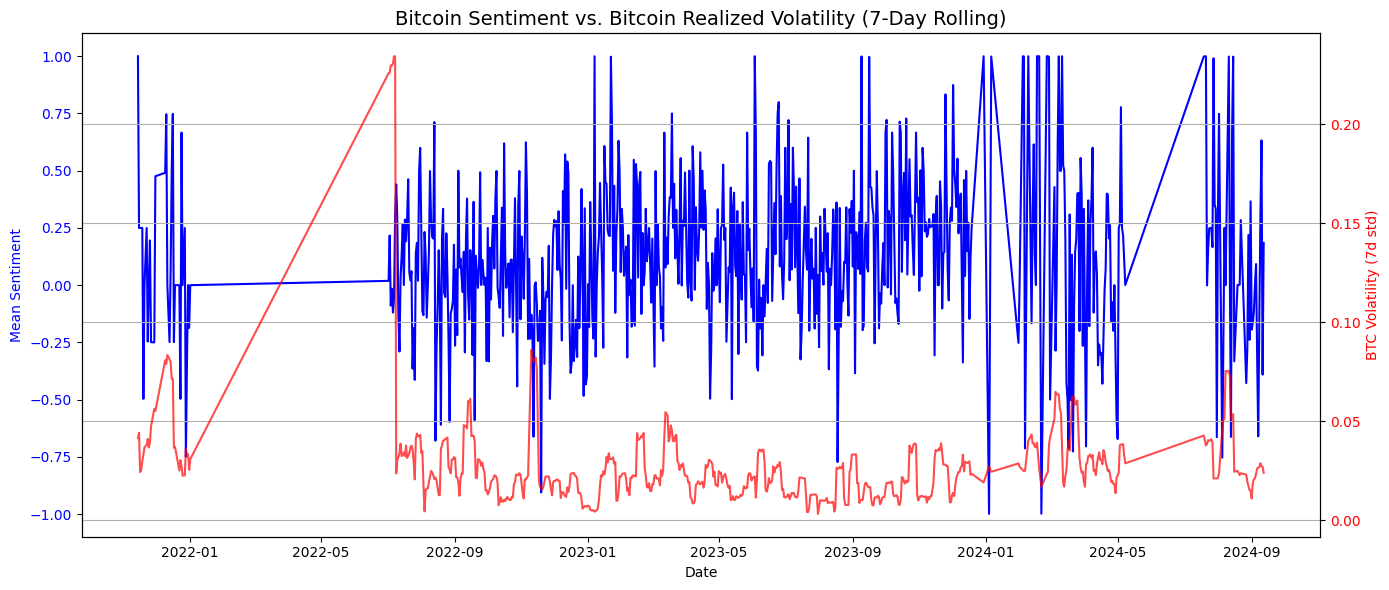

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load final dataset
df = pd.read_csv("crypto_sentiment_combined_final.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot mean_sentiment (left y-axis)
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean Sentiment', color='blue')
ax1.plot(df['Date'], df['mean_sentiment'], color='blue', label='BTC Sentiment', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='blue')

# Create secondary y-axis for volatility
ax2 = ax1.twinx()
ax2.set_ylabel('BTC Volatility (7d std)', color='red')
ax2.plot(df['Date'], df['BTC_Volatility'], color='red', label='BTC Volatility', linewidth=1.5, alpha=0.7)
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Bitcoin Sentiment vs. Bitcoin Realized Volatility (7-Day Rolling)', fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your full dataset
df = pd.read_csv("crypto_sentiment_combined_final.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Trim to where sentiment starts
df = df[df['Date'] >= '2021-10-12']


In [ ]:
df['smoothed_sentiment'] = df['mean_sentiment'].rolling(window=5, min_periods=1).mean()


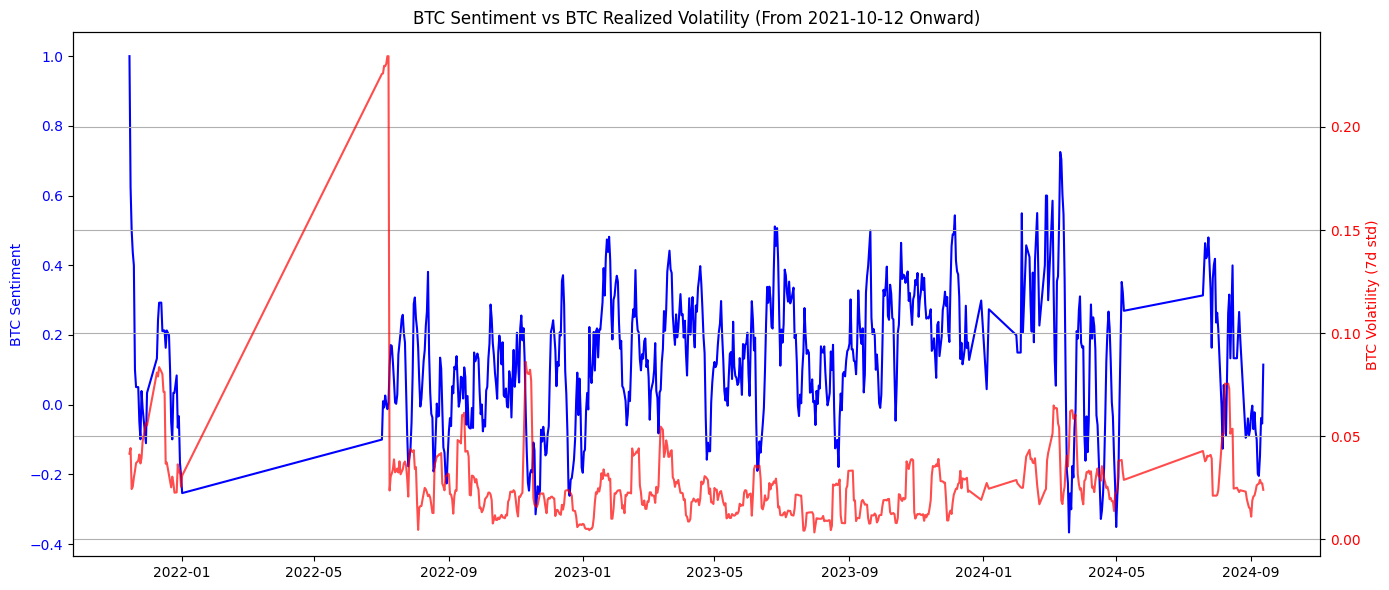

In [ ]:
plt.figure(figsize=(14, 6))
ax1 = plt.gca()

# Plot smoothed or raw sentiment
ax1.plot(df['Date'], df['smoothed_sentiment'], color='blue', label='BTC Sentiment (Smoothed)', linewidth=1.5)
ax1.set_ylabel('BTC Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Secondary axis for volatility
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['BTC_Volatility'], color='red', label='BTC Volatility', linewidth=1.5, alpha=0.7)
ax2.set_ylabel('BTC Volatility (7d std)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('BTC Sentiment vs BTC Realized Volatility (From 2021-10-12 Onward)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load and prepare data
df = pd.read_csv("/content/crypto_sentiment_combined_full (1).csv")
df['Date'] = pd.to_datetime(df['Date'])

# Filter from 2021-10-12 onward
df = df[df['Date'] >= '2021-10-12'].dropna()

# Select lag range
max_lag = 5

# Define function to run test
def run_granger_test(df, target_col, cause_col, max_lag):
    print(f"\n--- Granger Causality Test: Does {cause_col} → {target_col}? ---")
    test_df = df[[target_col, cause_col]].dropna()
    result = grangercausalitytests(test_df, maxlag=max_lag, verbose=True)

# Run tests: BTC sentiment → ETH, SOL, XRP Returns & Volatility
for coin in ['ETH', 'SOL', 'XRP']:
    run_granger_test(df, f'{coin}_Return', 'mean_sentiment', max_lag)
    run_granger_test(df, f'{coin}_Volatility', 'mean_sentiment', max_lag)



--- Granger Causality Test: Does mean_sentiment → ETH_Return? ---


KeyError: "['ETH_Return'] not in index"

In [ ]:
df = pd.read_csv("/content/crypto_sentiment_combined_full (1).csv")
df.head()

,Date,mean_sentiment,article_count,BTC_Close,BTC_Volume,BTC_Volatility,ETH_Close,ETH_Volume,ETH_Volatility,SOL_Close,SOL_Volume,SOL_Volatility,XRP_Close,XRP_Volume,XRP_Volatility,USDT_Close,USDT_Volume,USDT_Volatility
0,2021-11-05,0.399603,5,61019.66,1.262030e+09,0.029827,4480.09,1.023750e+09,0.028014,236.34,6.158675e+08,0.071732,1.160,8.192506e+07,0.056572,1.001,20560.99,0.029770
1,2021-11-06,0.000000,1,61529.76,9.395301e+08,0.023981,4521.41,8.892686e+08,0.044979,258.63,7.632217e+08,0.105399,1.152,5.194804e+07,0.065517,1.001,15450.19,0.023576
2,2021-11-08,-0.209941,4,67549.14,2.614940e+09,0.070339,4810.97,1.401094e+09,0.044902,248.35,7.817402e+08,0.050208,1.283,1.461790e+08,0.061475,1.001,39794.74,0.066334
3,2021-11-09,0.249908,4,66939.24,2.209552e+09,0.032596,4732.07,1.331651e+09,0.027254,239.03,6.523042e+08,0.063096,1.257,1.455686e+08,0.048324,1.000,32748.30,0.033267
4,2021-11-10,-0.249181,4,64926.06,3.365467e+09,0.086383,4632.98,2.133669e+09,0.079823,233.62,9.126253e+08,0.123206,1.192,2.843568e+08,0.176611,1.001,50618.81,0.089100


In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests


# Define the features to test
volatility_columns = ['ETH_Volatility', 'SOL_Volatility', 'XRP_Volatility']
target = 'mean_sentiment'

# Store results
granger_results = {}

# Run Granger causality tests for each volatility column
for col in volatility_columns:
    test_result = grangercausalitytests(master_df[[target, col]].dropna(), maxlag=5, verbose=False)
    summary = {}
    for lag in range(1, 6):
        p_val = test_result[lag][0]['ssr_ftest'][1]
        summary[f'Lag {lag}'] = p_val
    granger_results[col] = summary

# Format results into a DataFrame for easy viewing
results_df = pd.DataFrame(granger_results).T
results_df.columns = [f'Lag {i}' for i in range(1, 6)]

# import ace_tools as tools; tools.display_dataframe_to_user(name="Granger Causality: Volatility → BTC Sentiment", dataframe=results_df)
display(results_df)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
ETH_Volatility,0.292436,0.634278,0.903374,0.525090,0.652312
SOL_Volatility,0.697487,0.197548,0.320665,0.459966,0.575651
XRP_Volatility,0.156544,0.239548,0.411956,0.231445,0.300009


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Make sure the dataframe is sorted by date and contains no NaNs
df = master_df[['mean_sentiment', 'ETH_Volatility', 'SOL_Volatility', 'XRP_Volatility']].dropna()

max_lag = 5  # You can change this as needed

print("\n--- Granger Causality Test: ETH_Volatility → mean_sentiment ---")
grangercausalitytests(df[['mean_sentiment', 'ETH_Volatility']], maxlag=max_lag, verbose=True)

print("\n--- Granger Causality Test: SOL_Volatility → mean_sentiment ---")
grangercausalitytests(df[['mean_sentiment', 'SOL_Volatility']], maxlag=max_lag, verbose=True)

print("\n--- Granger Causality Test: XRP_Volatility → mean_sentiment ---")
grangercausalitytests(df[['mean_sentiment', 'XRP_Volatility']], maxlag=max_lag, verbose=True)



--- Granger Causality Test: ETH_Volatility → mean_sentiment ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1100  , p=0.2924  , df_denom=698, df_num=1
ssr based chi2 test:   chi2=1.1148  , p=0.2910  , df=1
likelihood ratio test: chi2=1.1139  , p=0.2912  , df=1
parameter F test:         F=1.1100  , p=0.2924  , df_denom=698, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4556  , p=0.6343  , df_denom=695, df_num=2
ssr based chi2 test:   chi2=0.9177  , p=0.6320  , df=2
likelihood ratio test: chi2=0.9171  , p=0.6322  , df=2
parameter F test:         F=0.4556  , p=0.6343  , df_denom=695, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1898  , p=0.9034  , df_denom=692, df_num=3
ssr based chi2 test:   chi2=0.5751  , p=0.9021  , df=3
likelihood ratio test: chi2=0.5749  , p=0.9022  , df=3
parameter F test:         F=0.1898  , p=0.9034  , df_denom=692, df_num=3

Granger Causality
number of 

{np.int64(1): ({'ssr_ftest': (np.float64(2.011629732697383),
    np.float64(0.15654386213570504),
    np.float64(698.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.020275705760552),
    np.float64(0.15521095783246708),
    np.int64(1)),
   'lrtest': (np.float64(2.017370078860722),
    np.float64(0.15550827438339213),
    np.int64(1)),
   'params_ftest': (np.float64(2.011629732697709),
    np.float64(0.15654386213567617),
    np.float64(698.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.4319446830131004),
    np.float64(0.23954776330396005),
    np.float64(695.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(2.8844928866450945),
    np.float64(0.23639611128216023),
    np.int64(2)),
   'lrtest': (np.float64(2.87856609191158),
    np.float64(0.23709768590462035),
    np.int64(2)),
   'params_ftest': (np.float64(1.431944683013084),
    np.float64(0.23954776330397914),
    np.float64(695.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
     

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Define lag range
max_lag = 5

# List of coins to test
coins = ['BTC', 'ETH', 'SOL', 'XRP']

# Run Granger causality tests in both directions
for coin in coins:
    print(f"\n--- Granger Causality Test: {coin}_Volume → mean_sentiment ---")
    grangercausalitytests(master_df[[ 'mean_sentiment', f'{coin}_Volume']].dropna(), maxlag=max_lag, verbose=True)

    print(f"\n--- Granger Causality Test: mean_sentiment → {coin}_Volume ---")
    grangercausalitytests(master_df[[f'{coin}_Volume', 'mean_sentiment']].dropna(), maxlag=max_lag, verbose=True)



--- Granger Causality Test: BTC_Volume → mean_sentiment ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0951  , p=0.2957  , df_denom=698, df_num=1
ssr based chi2 test:   chi2=1.0998  , p=0.2943  , df=1
likelihood ratio test: chi2=1.0989  , p=0.2945  , df=1
parameter F test:         F=1.0951  , p=0.2957  , df_denom=698, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9320  , p=0.1456  , df_denom=695, df_num=2
ssr based chi2 test:   chi2=3.8919  , p=0.1429  , df=2
likelihood ratio test: chi2=3.8811  , p=0.1436  , df=2
parameter F test:         F=1.9320  , p=0.1456  , df_denom=695, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7731  , p=0.1509  , df_denom=692, df_num=3
ssr based chi2 test:   chi2=5.3730  , p=0.1464  , df=3
likelihood ratio test: chi2=5.3525  , p=0.1477  , df=3
parameter F test:         F=1.7731  , p=0.1509  , df_denom=692, df_num=3

Granger Causality
number of lags

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


likelihood ratio test: chi2=6.9189  , p=0.1402  , df=4
parameter F test:         F=1.7159  , p=0.1446  , df_denom=689, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3646  , p=0.2356  , df_denom=686, df_num=5
ssr based chi2 test:   chi2=6.9322  , p=0.2257  , df=5
likelihood ratio test: chi2=6.8980  , p=0.2283  , df=5
parameter F test:         F=1.3646  , p=0.2356  , df_denom=686, df_num=5

--- Granger Causality Test: mean_sentiment → SOL_Volume ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.3059 , p=0.0000  , df_denom=698, df_num=1
ssr based chi2 test:   chi2=17.3802 , p=0.0000  , df=1
likelihood ratio test: chi2=17.1683 , p=0.0000  , df=1
parameter F test:         F=17.3059 , p=0.0000  , df_denom=698, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.1980  , p=0.0001  , df_denom=695, df_num=2
ssr based chi2 test:   chi2=18.5283 , p=0.0001  , df=2
likelihood ratio test: chi2=18.28

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
